# 0. Unzip Data

In [1]:
# Unzip data
import zipfile
with zipfile.ZipFile('/kaggle/input/data-science-bowl-2018/'+ 'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile('/kaggle/input/data-science-bowl-2018/' + 'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

# 1. Imports và Cấu hình

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF

import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# --- ⚙️ CONFIGURATION ---
TRAIN_DIR = "/kaggle/working/train"
TEST_DIR = "/kaggle/working/test"

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 100
SEED = 42

VALIDATION_SPLIT = 0.1 # 10%
TEST_SPLIT = 0.2       # 20%
EARLY_STOP_PATIENCE = 15

# --- THAY ĐỔI: Đường dẫn lưu model riêng biệt ---
UNET_SAVE_PATH = "/kaggle/working/best_unet_model.pth"
UNET_PLUS_PLUS_SAVE_PATH = "/kaggle/working/best_unet_pp_model.pth"
# -----------------------------------------------

# Cài đặt seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")

Using device: cuda


# 2. EDA, Visualize và Pre-load dữ liệu

--- 2. Starting EDA & Data Pre-loading ---
Loading, resizing, and collecting stats...


100%|██████████| 670/670 [04:32<00:00,  2.46it/s]


Data pre-loading complete. Loaded 670 images.

--- EDA Visualizations ---


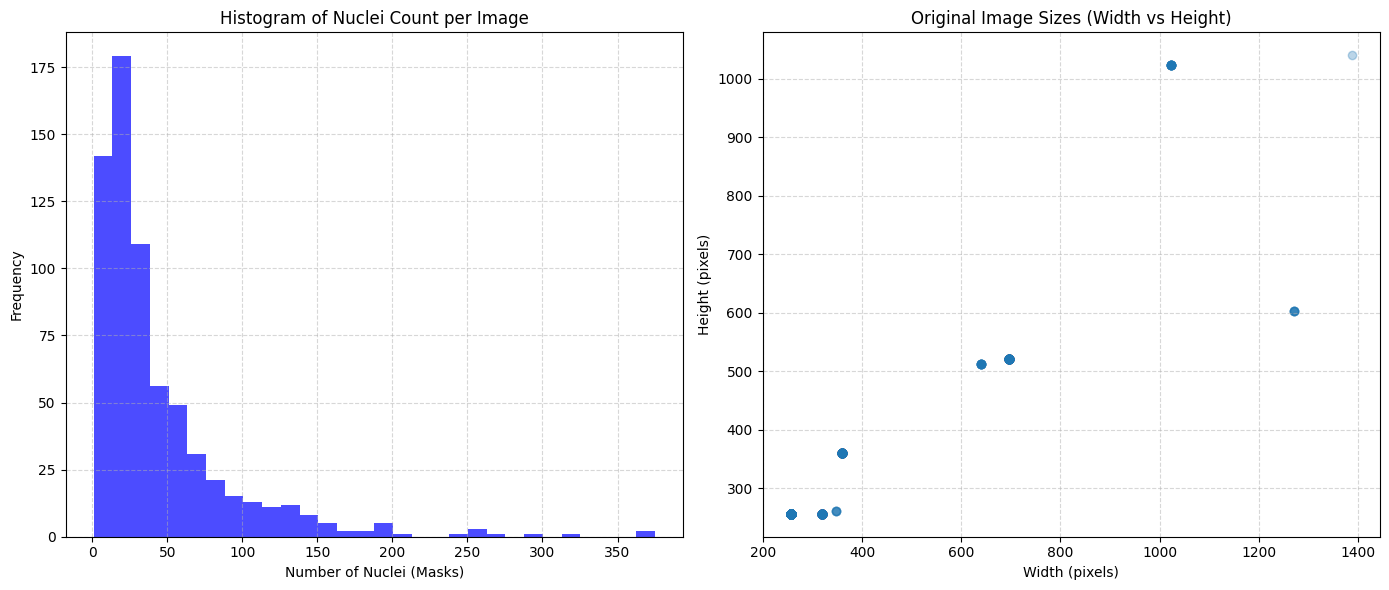


--- Sample Image and Combined Mask ---


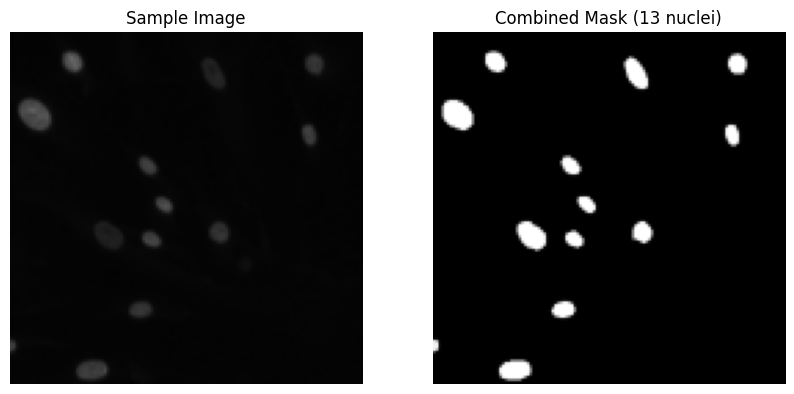

In [3]:
print("--- 2. Starting EDA & Data Pre-loading ---")

train_ids = next(os.walk(TRAIN_DIR))[1]

# Lists to store all data
X_data = [] # Original images (resized)
Y_data = [] # Combined masks (resized)

# Stats for EDA
original_sizes = []
mask_counts = []

print('Loading, resizing, and collecting stats...')
for id_ in tqdm(train_ids):
    path = os.path.join(TRAIN_DIR, id_)
    
    # --- Load Image & Stats ---
    img_path = os.path.join(path, 'images', id_ + '.png')
    img_original = imread(img_path)
    original_sizes.append(img_original.shape[:2]) # (H, W)
    
    # Resize image
    img = resize(img_original[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_data.append(img.astype(np.uint8))

    # --- Load Masks & Stats ---
    mask_path = os.path.join(path, 'masks')
    mask_files = next(os.walk(mask_path))[2]
    mask_counts.append(len(mask_files))
    
    # Combine masks
    mask_combined = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in mask_files:
        mask_ = imread(os.path.join(mask_path, mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask_combined = np.maximum(mask_combined, mask_)
    Y_data.append(mask_combined)

print(f"Data pre-loading complete. Loaded {len(X_data)} images.")

# --- Visualize Stats ---
print("\n--- EDA Visualizations ---")

# 1. Histogram of mask counts (Số lượng hạt nhân trên mỗi ảnh)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(mask_counts, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Nuclei Count per Image')
plt.xlabel('Number of Nuclei (Masks)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Scatter plot of original image sizes (Kích thước ảnh gốc)
plt.subplot(1, 2, 2)
sizes_np = np.array(original_sizes)
plt.scatter(sizes_np[:, 1], sizes_np[:, 0], alpha=0.3) # x=Width, y=Height
plt.title('Original Image Sizes (Width vs Height)')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Visualize a random sample (Xem ảnh và mask mẫu)
print("\n--- Sample Image and Combined Mask ---")
ix = random.randint(0, len(X_data) - 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_data[ix])
plt.title(f'Sample Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(Y_data[ix]), cmap='gray')
plt.title(f'Combined Mask ({mask_counts[ix]} nuclei)')
plt.axis('off')
plt.show()


--- 5 Sample Images and Combined Masks ---


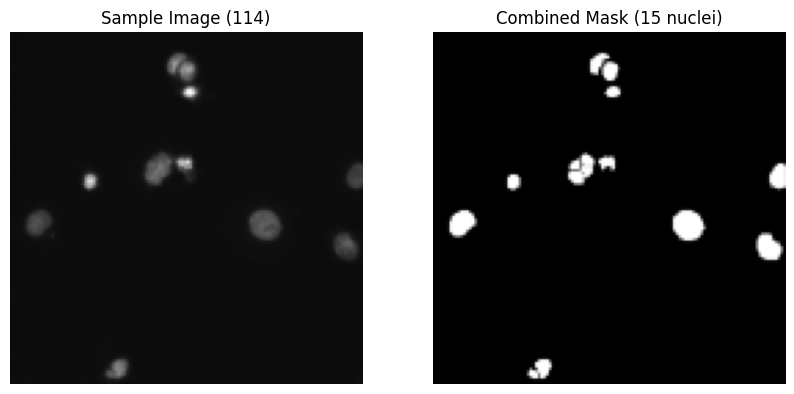

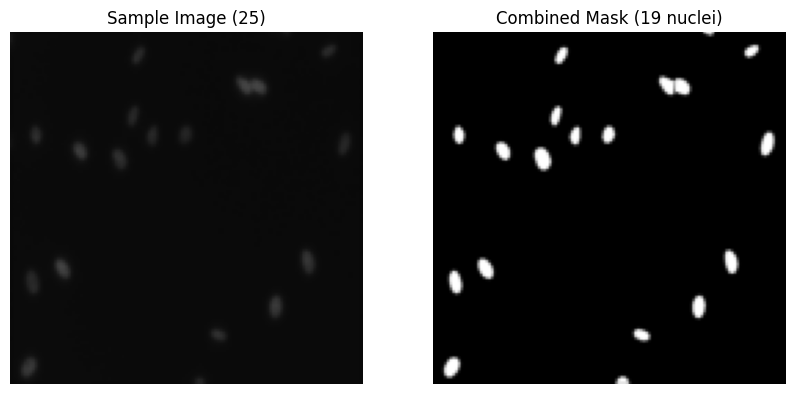

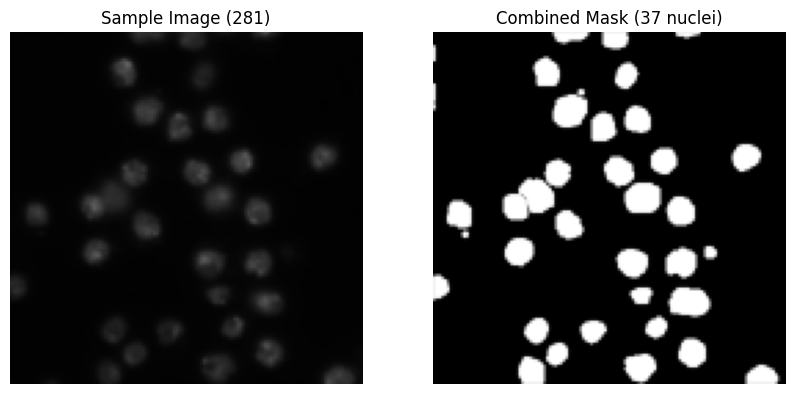

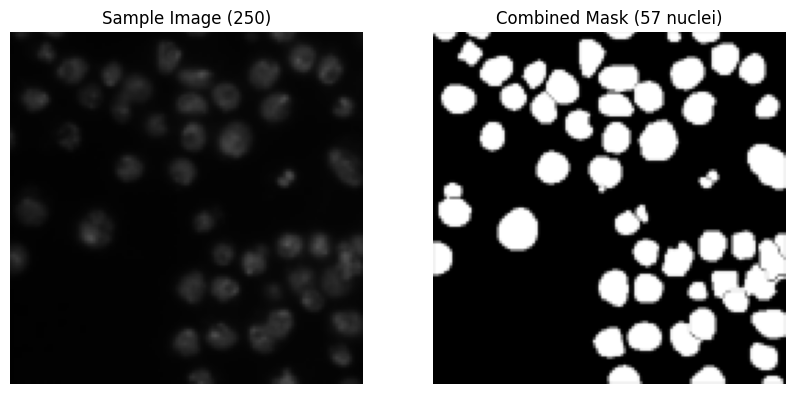

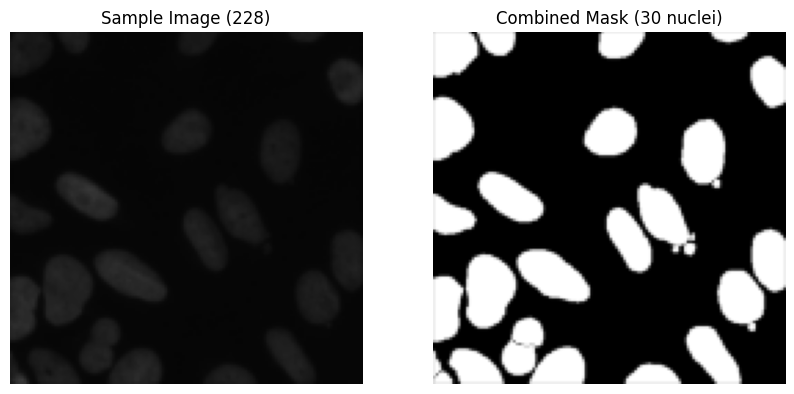

In [4]:
# 3. Visualize 5 random samples
print("\n--- 5 Sample Images and Combined Masks ---")

# Lấy 5 index ngẫu nhiên (không trùng lặp) từ bộ dữ liệu
indices = random.sample(range(len(X_data)), 5)

for ix in indices:
    # Lấy dữ liệu
    image = X_data[ix]
    mask = Y_data[ix]
    mask_count = mask_counts[ix]
    image_id = train_ids[ix]

    # Vẽ
    plt.figure(figsize=(10, 5))
    
    # Ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Sample Image ({ix})')
    plt.axis('off')

    # Mask tổng hợp
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask), cmap='gray')
    plt.title(f'Combined Mask ({mask_count} nuclei)')
    plt.axis('off')
    
    plt.show() # Hiển thị từng cặp ảnh

# 3. Định nghĩa Model U-Net

In [5]:
class ConvBlock(nn.Module):
    """(Conv2d -> BN -> ReLU) x 2"""
    # LƯU Ý: Đây là block giống hệt như trong UNet++
    # Nếu bạn đã định nghĩa nó ở Cell 3 (UNet++) rồi thì không cần định nghĩa lại
    # Nhưng để cell này độc lập, tôi sẽ thêm nó vào đây.
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    Implementation of U-Net (Viết theo style của UNet++)
    Sử dụng filter count: [32, 64, 128, 256, 512]
    """
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512]):
        super(UNet, self).__init__()
        nb_filter = features

        self.pool = nn.MaxPool2d(2, 2)
        # Sử dụng ConvTranspose2d cho nhất quán với U-Net gốc
        # (UNet++ dùng Upsample, nhưng ConvTranspose2d cũng rất phổ biến)
        # Bạn có thể đổi self.up4_t thành nn.Upsample(...) nếu muốn
        
        # --- Encoder ---
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        
        # --- Bottleneck ---
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        # --- Decoder ---
        # Up-sampling + ConvBlock
        self.up4_t = nn.ConvTranspose2d(nb_filter[4], nb_filter[3], kernel_size=2, stride=2)
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3]) # (skip + up) -> conv
        
        self.up3_t = nn.ConvTranspose2d(nb_filter[3], nb_filter[2], kernel_size=2, stride=2)
        self.conv2_1 = ConvBlock(nb_filter[3], nb_filter[2])
        
        self.up2_t = nn.ConvTranspose2d(nb_filter[2], nb_filter[1], kernel_size=2, stride=2)
        self.conv1_1 = ConvBlock(nb_filter[2], nb_filter[1])
        
        self.up1_t = nn.ConvTranspose2d(nb_filter[1], nb_filter[0], kernel_size=2, stride=2)
        self.conv0_1 = ConvBlock(nb_filter[1], nb_filter[0])

        # --- Final Output ---
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # --- Encoder path ---
        x0_0 = self.conv0_0(x)       # Skip 1 (32 filters)
        x1_0 = self.conv1_0(self.pool(x0_0)) # Skip 2 (64 filters)
        x2_0 = self.conv2_0(self.pool(x1_0)) # Skip 3 (128 filters)
        x3_0 = self.conv3_0(self.pool(x2_0)) # Skip 4 (256 filters)

        # --- Bottleneck ---
        x4_0 = self.conv4_0(self.pool(x3_0)) # (512 filters)

        # --- Decoder path ---
        # Tầng 4
        x3_1_up = self.up4_t(x4_0)
        # Cắt (crop) nếu kích thước không khớp (ít xảy ra với padding='same')
        if x3_1_up.shape != x3_0.shape:
             x3_1_up = TF.resize(x3_1_up, size=x3_0.shape[2:])
        x3_1_cat = torch.cat([x3_0, x3_1_up], 1) # Concat (256 + 256)
        x3_1 = self.conv3_1(x3_1_cat)
        
        # Tầng 3
        x2_1_up = self.up3_t(x3_1)
        if x2_1_up.shape != x2_0.shape:
             x2_1_up = TF.resize(x2_1_up, size=x2_0.shape[2:])
        x2_1_cat = torch.cat([x2_0, x2_1_up], 1) # Concat (128 + 128)
        x2_1 = self.conv2_1(x2_1_cat)

        # Tầng 2
        x1_1_up = self.up2_t(x2_1)
        if x1_1_up.shape != x1_0.shape:
             x1_1_up = TF.resize(x1_1_up, size=x1_0.shape[2:])
        x1_1_cat = torch.cat([x1_0, x1_1_up], 1) # Concat (64 + 64)
        x1_1 = self.conv1_1(x1_1_cat)
        
        # Tầng 1
        x0_1_up = self.up1_t(x1_1)
        if x0_1_up.shape != x0_0.shape:
             x0_1_up = TF.resize(x0_1_up, size=x0_0.shape[2:])
        x0_1_cat = torch.cat([x0_0, x0_1_up], 1) # Concat (32 + 32)
        x0_1 = self.conv0_1(x0_1_cat)
        
        # --- Output ---
        output = self.final(x0_1)
        return torch.sigmoid(output) # Sigmoid vì dùng BCELoss

# 4. Định nghĩa Model UNet++

In [6]:
class ConvBlock(nn.Module):
    """(Conv2d -> BN -> ReLU) x 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetPlusPlus(nn.Module):
    """
    Implementation of UNet++ (Nested U-Net)
    Sử dụng filter count từ Table 2: [32, 64, 128, 256, 512]
    """
    def __init__(self, in_channels=3, out_channels=1, 
                 filters=[32, 64, 128, 256, 512], deep_supervision=False):
        super(UNetPlusPlus, self).__init__()
        
        self.deep_supervision = deep_supervision
        nb_filter = filters

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Encoder path (X^i,0)
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        # Nested skip paths (X^i,j)
        # j=1
        self.conv0_1 = ConvBlock(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3] + nb_filter[4], nb_filter[3])
        
        # j=2
        self.conv0_2 = ConvBlock(nb_filter[0]*2 + nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2 + nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2 + nb_filter[3], nb_filter[2])
        
        # j=3
        self.conv0_3 = ConvBlock(nb_filter[0]*3 + nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3 + nb_filter[2], nb_filter[1])

        # j=4
        self.conv0_4 = ConvBlock(nb_filter[0]*4 + nb_filter[1], nb_filter[0])

        # Final output convs (cho deep supervision)
        # Áp dụng sigmoid ở cuối cùng
        self.final1 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        self.final2 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        self.final3 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        self.final4 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder (X^i,0)
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Nested path j=1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        # Nested path j=2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        # Nested path j=3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        
        # Nested path j=4
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        # Áp dụng sigmoid cho các output
        output1 = torch.sigmoid(self.final1(x0_1))
        output2 = torch.sigmoid(self.final2(x0_2))
        output3 = torch.sigmoid(self.final3(x0_3))
        output4 = torch.sigmoid(self.final4(x0_4))

        if self.deep_supervision:
            return [output1, output2, output3, output4]
        else:
            return output4

# 5. Dataset, Loss và Metrics

In [7]:
class DSB2018Dataset(Dataset):
    def __init__(self, X_data_list, Y_data_list, transform=None):
        self.transform = transform
        # Nhận dữ liệu đã được pre-load
        self.X_train_list = X_data_list
        self.Y_train_list = Y_data_list

    def __len__(self):
        return len(self.X_train_list)

    def __getitem__(self, index):
        image = self.X_train_list[index]
        mask = self.Y_train_list[index]
        
        # Chuẩn hóa ảnh (về [0, 1])
        image = image.astype(np.float32) / 255.0
        # Chuyển mask (về [0, 1])
        mask = (mask > 0).astype(np.float32)
        
        # Chuyển sang tensor (C, H, W)
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        if self.transform:
            # Bạn có thể thêm augmentation ở đây
            pass
            
        return image, mask

# --- LOSS FUNCTIONS --- (Không thay đổi)
class DiceLoss(nn.Module):
    # ... (giữ nguyên code)
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    # ... (giữ nguyên code)
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()
    def forward(self, inputs, targets):
        bce = self.bce_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return self.bce_weight * bce + self.dice_weight * dice

class DeepSupervisionLoss(nn.Module):
    # ... (giữ nguyên code)
    def __init__(self, bce_weight=0.5, dice_weight=0.5, weights=[0.25, 0.25, 0.25, 0.25]):
        super(DeepSupervisionLoss, self).__init__()
        self.base_loss = BCEDiceLoss(bce_weight, dice_weight)
        self.weights = weights
    def forward(self, inputs: list, target):
        total_loss = 0
        for i, pred in enumerate(inputs):
            if pred.shape != target.shape:
                 target_resized = F.interpolate(target, size=pred.shape[2:], mode='bilinear', align_corners=False)
            else:
                 target_resized = target
            total_loss += self.weights[i] * self.base_loss(pred, target_resized)
        return total_loss

# --- METRIC --- (Không thay đổi)
def iou_metric(pred, target, threshold=0.5, smooth=1e-6):
    # ... (giữ nguyên code)
    pred = (pred > threshold).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# 6. Hàm Training và Validation

In [8]:
def train_fn(loader, model, optimizer, loss_fn, device, deep_supervision):
    model.train()
    loop = tqdm(loader, desc="Training")
    
    total_loss = 0
    total_iou = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        predictions = model(data)
        
        if deep_supervision:
            loss = loss_fn(predictions, targets)
            iou_preds = predictions[-1] 
        else:
            loss = loss_fn(predictions, targets)
            iou_preds = predictions

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iou = iou_metric(iou_preds, targets)
        total_loss += loss.item()
        total_iou += iou.item()
        loop.set_postfix(loss=loss.item(), iou=iou.item())
        
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    print(f"Epoch Train Loss: {avg_loss:.4f}, Epoch Train IoU: {avg_iou:.4f}")
    # --- THÊM DÒNG NÀY ---
    return {"loss": avg_loss, "iou": avg_iou}

def val_fn(loader, model, loss_fn, device, deep_supervision):
    model.eval()
    loop = tqdm(loader, desc="Validation")
    val_loss = 0
    val_iou = 0
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=device)
            targets = targets.to(device=device)
            predictions = model(data)
            
            if deep_supervision:
                loss = loss_fn(predictions, targets)
                iou_preds = predictions[-1]
            else:
                loss = loss_fn(predictions, targets)
                iou_preds = predictions

            val_loss += loss.item()
            val_iou += iou_metric(iou_preds, targets).item()

    avg_loss = val_loss / len(loader)
    avg_iou = val_iou / len(loader)
    print(f"==> Avg Val Loss: {avg_loss:.4f}, Avg Val IoU: {avg_iou:.4f}")
    # --- THÊM DÒNG NÀY ---
    return {"loss": avg_loss, "iou": avg_iou}

# [HÀM MỚI] Dùng để đánh giá trên tập test cuối cùng
def evaluate_fn(loader, model, loss_fn, device, deep_supervision):
    model.eval()
    loop = tqdm(loader, desc="Evaluating Test Set")
    eval_loss = 0
    eval_iou = 0
    
    with torch.no_grad():
        for data, targets in loop:
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            
            if deep_supervision:
                loss = loss_fn(predictions, targets)
                iou_preds = predictions[-1]
            else:
                loss = loss_fn(predictions, targets)
                iou_preds = predictions
                
            eval_loss += loss.item()
            eval_iou += iou_metric(iou_preds, targets).item()
            
    avg_loss = eval_loss / len(loader)
    avg_iou = eval_iou / len(loader)
    return avg_loss, avg_iou

# 7. Khởi tạo và Huấn luyện

In [9]:
print("--- 3. Initializing Dataset & Splitting ---")

# (Code tải và chia data... giữ nguyên)
# ...
full_dataset = DSB2018Dataset(X_data_list=X_data, Y_data_list=Y_data)
total_size = len(full_dataset)
val_size = int(total_size * VALIDATION_SPLIT)
test_size = int(total_size * TEST_SPLIT)
train_size = total_size - val_size - test_size
print(f"Splitting data: {train_size} Train, {val_size} Validation, {test_size} Test")
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders created.")

# --- Nơi lưu kết quả test cuối cùng ---
final_test_results = {}
# --- MỚI: Nơi lưu lịch sử training ---
training_histories = {
    "unet": {"train_loss": [], "train_iou": [], "val_loss": [], "val_iou": []},
    "unet_pp": {"train_loss": [], "train_iou": [], "val_loss": [], "val_iou": []}
}

# ======================================================================
# --- BƯỚC 4A: HUẤN LUYỆN VÀ ĐÁNH GIÁ UNET ---
# ======================================================================
print(f"\n" + "="*50)
print(f"--- 4. STARTING UNET TRAINING ---")
print("="*50)

model_unet = UNet(in_channels=IMG_CHANNELS, out_channels=1).to(DEVICE)
loss_fn_unet = BCEDiceLoss()
optimizer_unet = optim.Adam(model_unet.parameters(), lr=LEARNING_RATE)
best_val_iou = -1.0
early_stop_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_metrics = train_fn(train_loader, model_unet, optimizer_unet, loss_fn_unet, DEVICE, deep_supervision=False)
    val_metrics = val_fn(val_loader, model_unet, loss_fn_unet, DEVICE, deep_supervision=False)
    
    # --- MỚI: Lưu lịch sử ---
    training_histories["unet"]["train_loss"].append(train_metrics["loss"])
    training_histories["unet"]["train_iou"].append(train_metrics["iou"])
    training_histories["unet"]["val_loss"].append(val_metrics["loss"])
    training_histories["unet"]["val_iou"].append(val_metrics["iou"])
    # -----------------------

    current_val_iou = val_metrics["iou"]
    if current_val_iou > best_val_iou:
        best_val_iou = current_val_iou
        print(f"🎉 New best UNet model! Val IoU: {best_val_iou:.4f}. Saving model to {UNET_SAVE_PATH}")
        torch.save(model_unet.state_dict(), UNET_SAVE_PATH)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Val IoU did not improve. Counter: {early_stop_counter}/{EARLY_STOP_PATIENCE}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f"--- UNet Early stopping triggered after {epoch+1} epochs ---")
        break

print("\n--- UNet Training Finished ---")
print(f"\n--- Evaluating UNet on Test Set ---")
model_unet.load_state_dict(torch.load(UNET_SAVE_PATH))
test_loss, test_iou = evaluate_fn(test_loader, model_unet, loss_fn_unet, DEVICE, deep_supervision=False)
final_test_results["UNet"] = {"loss": test_loss, "iou": test_iou}



--- 3. Initializing Dataset & Splitting ---
Splitting data: 469 Train, 67 Validation, 134 Test
DataLoaders created.

--- 4. STARTING UNET TRAINING ---

Epoch 1/100


Training: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, iou=0.743, loss=0.394]


Epoch Train Loss: 0.5425, Epoch Train IoU: 0.5513


Validation: 100%|██████████| 5/5 [00:00<00:00, 36.19it/s]


==> Avg Val Loss: 0.6139, Avg Val IoU: 0.5642
🎉 New best UNet model! Val IoU: 0.5642. Saving model to /kaggle/working/best_unet_model.pth

Epoch 2/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.81it/s, iou=0.801, loss=0.343]


Epoch Train Loss: 0.4241, Epoch Train IoU: 0.6858


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.55it/s]


==> Avg Val Loss: 0.4128, Avg Val IoU: 0.7327
🎉 New best UNet model! Val IoU: 0.7327. Saving model to /kaggle/working/best_unet_model.pth

Epoch 3/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.88it/s, iou=0.751, loss=0.375]


Epoch Train Loss: 0.3840, Epoch Train IoU: 0.7299


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.63it/s]


==> Avg Val Loss: 0.3763, Avg Val IoU: 0.7151
Val IoU did not improve. Counter: 1/15

Epoch 4/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.80it/s, iou=0.834, loss=0.321]


Epoch Train Loss: 0.3649, Epoch Train IoU: 0.7555


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.83it/s]


==> Avg Val Loss: 0.3523, Avg Val IoU: 0.7873
🎉 New best UNet model! Val IoU: 0.7873. Saving model to /kaggle/working/best_unet_model.pth

Epoch 5/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.82it/s, iou=0.689, loss=0.425]


Epoch Train Loss: 0.3552, Epoch Train IoU: 0.7584


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.99it/s]


==> Avg Val Loss: 0.3465, Avg Val IoU: 0.7803
Val IoU did not improve. Counter: 1/15

Epoch 6/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.77it/s, iou=0.474, loss=0.559]


Epoch Train Loss: 0.3430, Epoch Train IoU: 0.7773


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.74it/s]


==> Avg Val Loss: 0.3491, Avg Val IoU: 0.7690
Val IoU did not improve. Counter: 2/15

Epoch 7/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.68it/s, iou=0.778, loss=0.325]


Epoch Train Loss: 0.3296, Epoch Train IoU: 0.7927


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.78it/s]


==> Avg Val Loss: 0.3214, Avg Val IoU: 0.8000
🎉 New best UNet model! Val IoU: 0.8000. Saving model to /kaggle/working/best_unet_model.pth

Epoch 8/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.68it/s, iou=0.876, loss=0.273]


Epoch Train Loss: 0.3141, Epoch Train IoU: 0.8107


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.08it/s]


==> Avg Val Loss: 0.3145, Avg Val IoU: 0.8238
🎉 New best UNet model! Val IoU: 0.8238. Saving model to /kaggle/working/best_unet_model.pth

Epoch 9/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.73it/s, iou=0.837, loss=0.238]


Epoch Train Loss: 0.3105, Epoch Train IoU: 0.8052


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.57it/s]


==> Avg Val Loss: 0.3058, Avg Val IoU: 0.8176
Val IoU did not improve. Counter: 1/15

Epoch 10/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.75it/s, iou=0.866, loss=0.269]


Epoch Train Loss: 0.2968, Epoch Train IoU: 0.8234


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]


==> Avg Val Loss: 0.2928, Avg Val IoU: 0.8532
🎉 New best UNet model! Val IoU: 0.8532. Saving model to /kaggle/working/best_unet_model.pth

Epoch 11/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.75it/s, iou=0.698, loss=0.387]


Epoch Train Loss: 0.2893, Epoch Train IoU: 0.8266


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.09it/s]


==> Avg Val Loss: 0.2941, Avg Val IoU: 0.8324
Val IoU did not improve. Counter: 1/15

Epoch 12/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.79it/s, iou=0.87, loss=0.259] 


Epoch Train Loss: 0.2840, Epoch Train IoU: 0.8308


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


==> Avg Val Loss: 0.2821, Avg Val IoU: 0.8413
Val IoU did not improve. Counter: 2/15

Epoch 13/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.84it/s, iou=0.583, loss=0.409]


Epoch Train Loss: 0.2821, Epoch Train IoU: 0.8257


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


==> Avg Val Loss: 0.2855, Avg Val IoU: 0.8353
Val IoU did not improve. Counter: 3/15

Epoch 14/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.82it/s, iou=0.864, loss=0.238]


Epoch Train Loss: 0.2787, Epoch Train IoU: 0.8138


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.86it/s]


==> Avg Val Loss: 0.2679, Avg Val IoU: 0.8410
Val IoU did not improve. Counter: 4/15

Epoch 15/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.88it/s, iou=0.82, loss=0.238] 


Epoch Train Loss: 0.2721, Epoch Train IoU: 0.8164


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.39it/s]


==> Avg Val Loss: 0.2659, Avg Val IoU: 0.8631
🎉 New best UNet model! Val IoU: 0.8631. Saving model to /kaggle/working/best_unet_model.pth

Epoch 16/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.90it/s, iou=0.869, loss=0.202]


Epoch Train Loss: 0.2591, Epoch Train IoU: 0.8399


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.90it/s]


==> Avg Val Loss: 0.2520, Avg Val IoU: 0.8513
Val IoU did not improve. Counter: 1/15

Epoch 17/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.83it/s, iou=0.781, loss=0.26] 


Epoch Train Loss: 0.2512, Epoch Train IoU: 0.8441


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.73it/s]


==> Avg Val Loss: 0.2460, Avg Val IoU: 0.8598
Val IoU did not improve. Counter: 2/15

Epoch 18/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.92it/s, iou=0.851, loss=0.252]


Epoch Train Loss: 0.2413, Epoch Train IoU: 0.8560


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.67it/s]


==> Avg Val Loss: 0.2450, Avg Val IoU: 0.8461
Val IoU did not improve. Counter: 3/15

Epoch 19/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.90it/s, iou=0.89, loss=0.215] 


Epoch Train Loss: 0.2346, Epoch Train IoU: 0.8606


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


==> Avg Val Loss: 0.2390, Avg Val IoU: 0.8569
Val IoU did not improve. Counter: 4/15

Epoch 20/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.82it/s, iou=0.859, loss=0.193]


Epoch Train Loss: 0.2316, Epoch Train IoU: 0.8559


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.57it/s]


==> Avg Val Loss: 0.2249, Avg Val IoU: 0.8552
Val IoU did not improve. Counter: 5/15

Epoch 21/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.87it/s, iou=0.866, loss=0.207]


Epoch Train Loss: 0.2244, Epoch Train IoU: 0.8611


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]


==> Avg Val Loss: 0.2263, Avg Val IoU: 0.8679
🎉 New best UNet model! Val IoU: 0.8679. Saving model to /kaggle/working/best_unet_model.pth

Epoch 22/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.90it/s, iou=0.821, loss=0.228]


Epoch Train Loss: 0.2175, Epoch Train IoU: 0.8660


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.90it/s]


==> Avg Val Loss: 0.2172, Avg Val IoU: 0.8688
🎉 New best UNet model! Val IoU: 0.8688. Saving model to /kaggle/working/best_unet_model.pth

Epoch 23/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.82it/s, iou=0.838, loss=0.189]


Epoch Train Loss: 0.2134, Epoch Train IoU: 0.8637


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.25it/s]


==> Avg Val Loss: 0.2113, Avg Val IoU: 0.8704
🎉 New best UNet model! Val IoU: 0.8704. Saving model to /kaggle/working/best_unet_model.pth

Epoch 24/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.93it/s, iou=0.761, loss=0.304]


Epoch Train Loss: 0.2118, Epoch Train IoU: 0.8649


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s]


==> Avg Val Loss: 0.2146, Avg Val IoU: 0.8562
Val IoU did not improve. Counter: 1/15

Epoch 25/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.91it/s, iou=0.85, loss=0.285] 


Epoch Train Loss: 0.2103, Epoch Train IoU: 0.8599


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.89it/s]


==> Avg Val Loss: 0.2166, Avg Val IoU: 0.8627
Val IoU did not improve. Counter: 2/15

Epoch 26/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.85it/s, iou=0.893, loss=0.148]


Epoch Train Loss: 0.1984, Epoch Train IoU: 0.8740


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


==> Avg Val Loss: 0.1936, Avg Val IoU: 0.8810
🎉 New best UNet model! Val IoU: 0.8810. Saving model to /kaggle/working/best_unet_model.pth

Epoch 27/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.92it/s, iou=0.835, loss=0.214]


Epoch Train Loss: 0.1916, Epoch Train IoU: 0.8761


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.99it/s]


==> Avg Val Loss: 0.1952, Avg Val IoU: 0.8747
Val IoU did not improve. Counter: 1/15

Epoch 28/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.92it/s, iou=0.821, loss=0.232]


Epoch Train Loss: 0.1914, Epoch Train IoU: 0.8760


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


==> Avg Val Loss: 0.1974, Avg Val IoU: 0.8708
Val IoU did not improve. Counter: 2/15

Epoch 29/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.87it/s, iou=0.871, loss=0.228]


Epoch Train Loss: 0.1884, Epoch Train IoU: 0.8758


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


==> Avg Val Loss: 0.2040, Avg Val IoU: 0.8745
Val IoU did not improve. Counter: 3/15

Epoch 30/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.89it/s, iou=0.732, loss=0.337]


Epoch Train Loss: 0.1833, Epoch Train IoU: 0.8801


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.89it/s]


==> Avg Val Loss: 0.1858, Avg Val IoU: 0.8763
Val IoU did not improve. Counter: 4/15

Epoch 31/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.87it/s, iou=0.853, loss=0.242]


Epoch Train Loss: 0.1778, Epoch Train IoU: 0.8802


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.91it/s]


==> Avg Val Loss: 0.1991, Avg Val IoU: 0.8288
Val IoU did not improve. Counter: 5/15

Epoch 32/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.80it/s, iou=0.915, loss=0.137]


Epoch Train Loss: 0.1745, Epoch Train IoU: 0.8791


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.27it/s]


==> Avg Val Loss: 0.1792, Avg Val IoU: 0.8801
Val IoU did not improve. Counter: 6/15

Epoch 33/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.90it/s, iou=0.823, loss=0.209]


Epoch Train Loss: 0.1669, Epoch Train IoU: 0.8884


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]


==> Avg Val Loss: 0.1788, Avg Val IoU: 0.8827
🎉 New best UNet model! Val IoU: 0.8827. Saving model to /kaggle/working/best_unet_model.pth

Epoch 34/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.77it/s, iou=0.876, loss=0.143]


Epoch Train Loss: 0.1626, Epoch Train IoU: 0.8933


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.49it/s]


==> Avg Val Loss: 0.1731, Avg Val IoU: 0.8539
Val IoU did not improve. Counter: 1/15

Epoch 35/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.91it/s, iou=0.896, loss=0.127]


Epoch Train Loss: 0.1542, Epoch Train IoU: 0.8979


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]


==> Avg Val Loss: 0.1672, Avg Val IoU: 0.8763
Val IoU did not improve. Counter: 2/15

Epoch 36/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.85it/s, iou=0.76, loss=0.298] 


Epoch Train Loss: 0.1542, Epoch Train IoU: 0.9002


Validation: 100%|██████████| 5/5 [00:00<00:00, 44.78it/s]


==> Avg Val Loss: 0.1685, Avg Val IoU: 0.8801
Val IoU did not improve. Counter: 3/15

Epoch 37/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.85it/s, iou=0.91, loss=0.131] 


Epoch Train Loss: 0.1454, Epoch Train IoU: 0.9063


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.93it/s]


==> Avg Val Loss: 0.1673, Avg Val IoU: 0.8781
Val IoU did not improve. Counter: 4/15

Epoch 38/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.99it/s, iou=0.75, loss=0.302] 


Epoch Train Loss: 0.1437, Epoch Train IoU: 0.9085


Validation: 100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


==> Avg Val Loss: 0.1653, Avg Val IoU: 0.8719
Val IoU did not improve. Counter: 5/15

Epoch 39/100


Training: 100%|██████████| 30/30 [00:01<00:00, 15.00it/s, iou=0.831, loss=0.219]


Epoch Train Loss: 0.1523, Epoch Train IoU: 0.8841


Validation: 100%|██████████| 5/5 [00:00<00:00, 43.24it/s]


==> Avg Val Loss: 0.1575, Avg Val IoU: 0.8760
Val IoU did not improve. Counter: 6/15

Epoch 40/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.94it/s, iou=0.844, loss=0.193]


Epoch Train Loss: 0.1402, Epoch Train IoU: 0.9035


Validation: 100%|██████████| 5/5 [00:00<00:00, 46.27it/s]


==> Avg Val Loss: 0.1565, Avg Val IoU: 0.8748
Val IoU did not improve. Counter: 7/15

Epoch 41/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.98it/s, iou=0.604, loss=0.349]


Epoch Train Loss: 0.1360, Epoch Train IoU: 0.9078


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.79it/s]


==> Avg Val Loss: 0.1599, Avg Val IoU: 0.8708
Val IoU did not improve. Counter: 8/15

Epoch 42/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.97it/s, iou=0.906, loss=0.123]


Epoch Train Loss: 0.1300, Epoch Train IoU: 0.9104


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


==> Avg Val Loss: 0.1440, Avg Val IoU: 0.8815
Val IoU did not improve. Counter: 9/15

Epoch 43/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.93it/s, iou=0.933, loss=0.0904]


Epoch Train Loss: 0.1293, Epoch Train IoU: 0.9120


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.00it/s]


==> Avg Val Loss: 0.1450, Avg Val IoU: 0.8725
Val IoU did not improve. Counter: 10/15

Epoch 44/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.81it/s, iou=0.901, loss=0.183] 


Epoch Train Loss: 0.1232, Epoch Train IoU: 0.9207


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.57it/s]


==> Avg Val Loss: 0.1614, Avg Val IoU: 0.8667
Val IoU did not improve. Counter: 11/15

Epoch 45/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.95it/s, iou=0.883, loss=0.158] 


Epoch Train Loss: 0.1178, Epoch Train IoU: 0.9232


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.63it/s]


==> Avg Val Loss: 0.1459, Avg Val IoU: 0.8650
Val IoU did not improve. Counter: 12/15

Epoch 46/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.93it/s, iou=0.899, loss=0.139] 


Epoch Train Loss: 0.1135, Epoch Train IoU: 0.9247


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


==> Avg Val Loss: 0.1404, Avg Val IoU: 0.8752
Val IoU did not improve. Counter: 13/15

Epoch 47/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.89it/s, iou=0.952, loss=0.0898]


Epoch Train Loss: 0.1076, Epoch Train IoU: 0.9323


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.88it/s]


==> Avg Val Loss: 0.1339, Avg Val IoU: 0.8804
Val IoU did not improve. Counter: 14/15

Epoch 48/100


Training: 100%|██████████| 30/30 [00:02<00:00, 14.92it/s, iou=0.847, loss=0.139] 


Epoch Train Loss: 0.1061, Epoch Train IoU: 0.9350


Validation: 100%|██████████| 5/5 [00:00<00:00, 45.59it/s]


==> Avg Val Loss: 0.1381, Avg Val IoU: 0.8734
Val IoU did not improve. Counter: 15/15
--- UNet Early stopping triggered after 48 epochs ---

--- UNet Training Finished ---

--- Evaluating UNet on Test Set ---


Evaluating Test Set: 100%|██████████| 9/9 [00:00<00:00, 38.40it/s]


In [10]:
# ======================================================================
# --- BƯỚC 4B: HUẤN LUYỆN VÀ ĐÁNH GIÁ UNET++ ---
# ======================================================================
print(f"\n" + "="*50)
print(f"--- 5. STARTING UNET++ TRAINING ---")
print("="*50)

USE_DEEP_SUPERVISION = True
model_unet_pp = UNetPlusPlus(in_channels=IMG_CHANNELS, out_channels=1, 
                             deep_supervision=USE_DEEP_SUPERVISION).to(DEVICE)
if USE_DEEP_SUPERVISION:
    print("Using Deep Supervision Loss for UNet++.")
    loss_fn_unet_pp = DeepSupervisionLoss()
else:
    print("Using standard BCEDice Loss for UNet++.")
    loss_fn_unet_pp = BCEDiceLoss()
optimizer_unet_pp = optim.Adam(model_unet_pp.parameters(), lr=LEARNING_RATE)
best_val_iou = -1.0
early_stop_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_metrics = train_fn(train_loader, model_unet_pp, optimizer_unet_pp, loss_fn_unet_pp, DEVICE, USE_DEEP_SUPERVISION)
    val_metrics = val_fn(val_loader, model_unet_pp, loss_fn_unet_pp, DEVICE, USE_DEEP_SUPERVISION)
    
    # --- MỚI: Lưu lịch sử ---
    training_histories["unet_pp"]["train_loss"].append(train_metrics["loss"])
    training_histories["unet_pp"]["train_iou"].append(train_metrics["iou"])
    training_histories["unet_pp"]["val_loss"].append(val_metrics["loss"])
    training_histories["unet_pp"]["val_iou"].append(val_metrics["iou"])
    # -----------------------

    current_val_iou = val_metrics["iou"]
    if current_val_iou > best_val_iou:
        best_val_iou = current_val_iou
        print(f"🎉 New best UNet++ model! Val IoU: {best_val_iou:.4f}. Saving model to {UNET_PLUS_PLUS_SAVE_PATH}")
        torch.save(model_unet_pp.state_dict(), UNET_PLUS_PLUS_SAVE_PATH)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Val IoU did not improve. Counter: {early_stop_counter}/{EARLY_STOP_PATIENCE}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f"--- UNet++ Early stopping triggered after {epoch+1} epochs ---")
        break

print("\n--- UNet++ Training Finished ---")
print(f"\n--- Evaluating UNet++ on Test Set ---")
model_unet_pp.load_state_dict(torch.load(UNET_PLUS_PLUS_SAVE_PATH))
test_loss, test_iou = evaluate_fn(test_loader, model_unet_pp, loss_fn_unet_pp, DEVICE, USE_DEEP_SUPERVISION)
final_test_results["UNet++"] = {"loss": test_loss, "iou": test_iou}


--- 5. STARTING UNET++ TRAINING ---
Using Deep Supervision Loss for UNet++.

Epoch 1/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.37it/s, iou=0.62, loss=0.466] 


Epoch Train Loss: 0.5238, Epoch Train IoU: 0.5573


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


==> Avg Val Loss: 0.6273, Avg Val IoU: 0.0216
🎉 New best UNet++ model! Val IoU: 0.0216. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 2/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, iou=0.406, loss=0.575]


Epoch Train Loss: 0.4183, Epoch Train IoU: 0.7031


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.93it/s]


==> Avg Val Loss: 0.4277, Avg Val IoU: 0.6626
🎉 New best UNet++ model! Val IoU: 0.6626. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 3/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, iou=0.583, loss=0.49] 


Epoch Train Loss: 0.3851, Epoch Train IoU: 0.7428


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.3789, Avg Val IoU: 0.7695
🎉 New best UNet++ model! Val IoU: 0.7695. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 4/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.501, loss=0.548]


Epoch Train Loss: 0.3640, Epoch Train IoU: 0.7728


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.04it/s]


==> Avg Val Loss: 0.3517, Avg Val IoU: 0.7877
🎉 New best UNet++ model! Val IoU: 0.7877. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 5/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, iou=0.783, loss=0.354]


Epoch Train Loss: 0.3448, Epoch Train IoU: 0.7815


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.87it/s]


==> Avg Val Loss: 0.3529, Avg Val IoU: 0.8048
🎉 New best UNet++ model! Val IoU: 0.8048. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 6/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s, iou=0.858, loss=0.306]


Epoch Train Loss: 0.3314, Epoch Train IoU: 0.8016


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


==> Avg Val Loss: 0.3301, Avg Val IoU: 0.8328
🎉 New best UNet++ model! Val IoU: 0.8328. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 7/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, iou=0.818, loss=0.256]


Epoch Train Loss: 0.3189, Epoch Train IoU: 0.8080


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.91it/s]


==> Avg Val Loss: 0.3230, Avg Val IoU: 0.8053
Val IoU did not improve. Counter: 1/15

Epoch 8/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, iou=0.8, loss=0.267]  


Epoch Train Loss: 0.3138, Epoch Train IoU: 0.8079


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


==> Avg Val Loss: 0.3056, Avg Val IoU: 0.8278
Val IoU did not improve. Counter: 2/15

Epoch 9/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, iou=0.776, loss=0.264]


Epoch Train Loss: 0.3022, Epoch Train IoU: 0.8088


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.75it/s]


==> Avg Val Loss: 0.3027, Avg Val IoU: 0.8439
🎉 New best UNet++ model! Val IoU: 0.8439. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 10/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, iou=0.843, loss=0.259]


Epoch Train Loss: 0.2920, Epoch Train IoU: 0.8256


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


==> Avg Val Loss: 0.2912, Avg Val IoU: 0.8507
🎉 New best UNet++ model! Val IoU: 0.8507. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 11/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, iou=0.844, loss=0.274]


Epoch Train Loss: 0.2829, Epoch Train IoU: 0.8296


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


==> Avg Val Loss: 0.2915, Avg Val IoU: 0.8319
Val IoU did not improve. Counter: 1/15

Epoch 12/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s, iou=0.827, loss=0.285]


Epoch Train Loss: 0.2768, Epoch Train IoU: 0.8325


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.2801, Avg Val IoU: 0.8539
🎉 New best UNet++ model! Val IoU: 0.8539. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 13/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.741, loss=0.285]


Epoch Train Loss: 0.2680, Epoch Train IoU: 0.8351


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


==> Avg Val Loss: 0.2870, Avg Val IoU: 0.8228
Val IoU did not improve. Counter: 1/15

Epoch 14/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.87, loss=0.218] 


Epoch Train Loss: 0.2676, Epoch Train IoU: 0.8305


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


==> Avg Val Loss: 0.2676, Avg Val IoU: 0.8388
Val IoU did not improve. Counter: 2/15

Epoch 15/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.844, loss=0.251]


Epoch Train Loss: 0.2529, Epoch Train IoU: 0.8448


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


==> Avg Val Loss: 0.2458, Avg Val IoU: 0.8639
🎉 New best UNet++ model! Val IoU: 0.8639. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 16/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.619, loss=0.395]


Epoch Train Loss: 0.2523, Epoch Train IoU: 0.8380


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


==> Avg Val Loss: 0.2560, Avg Val IoU: 0.8313
Val IoU did not improve. Counter: 1/15

Epoch 17/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.753, loss=0.306]


Epoch Train Loss: 0.2422, Epoch Train IoU: 0.8490


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


==> Avg Val Loss: 0.2453, Avg Val IoU: 0.8436
Val IoU did not improve. Counter: 2/15

Epoch 18/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s, iou=0.872, loss=0.227]


Epoch Train Loss: 0.2310, Epoch Train IoU: 0.8571


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


==> Avg Val Loss: 0.2379, Avg Val IoU: 0.8598
Val IoU did not improve. Counter: 3/15

Epoch 19/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s, iou=0.88, loss=0.228] 


Epoch Train Loss: 0.2255, Epoch Train IoU: 0.8557


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.2300, Avg Val IoU: 0.8636
Val IoU did not improve. Counter: 4/15

Epoch 20/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.837, loss=0.206]


Epoch Train Loss: 0.2169, Epoch Train IoU: 0.8668


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


==> Avg Val Loss: 0.2221, Avg Val IoU: 0.8666
🎉 New best UNet++ model! Val IoU: 0.8666. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 21/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, iou=0.913, loss=0.206]


Epoch Train Loss: 0.2142, Epoch Train IoU: 0.8666


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.93it/s]


==> Avg Val Loss: 0.2190, Avg Val IoU: 0.8633
Val IoU did not improve. Counter: 1/15

Epoch 22/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.886, loss=0.2]  


Epoch Train Loss: 0.2083, Epoch Train IoU: 0.8686


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.11it/s]


==> Avg Val Loss: 0.2141, Avg Val IoU: 0.8594
Val IoU did not improve. Counter: 2/15

Epoch 23/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.804, loss=0.223]


Epoch Train Loss: 0.2028, Epoch Train IoU: 0.8671


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.77it/s]


==> Avg Val Loss: 0.1997, Avg Val IoU: 0.8680
🎉 New best UNet++ model! Val IoU: 0.8680. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 24/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.85, loss=0.181] 


Epoch Train Loss: 0.1999, Epoch Train IoU: 0.8677


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.2002, Avg Val IoU: 0.8754
🎉 New best UNet++ model! Val IoU: 0.8754. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 25/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.894, loss=0.169]


Epoch Train Loss: 0.1972, Epoch Train IoU: 0.8648


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


==> Avg Val Loss: 0.1923, Avg Val IoU: 0.8674
Val IoU did not improve. Counter: 1/15

Epoch 26/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.873, loss=0.173]


Epoch Train Loss: 0.1875, Epoch Train IoU: 0.8731


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


==> Avg Val Loss: 0.1868, Avg Val IoU: 0.8874
🎉 New best UNet++ model! Val IoU: 0.8874. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 27/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.873, loss=0.207]


Epoch Train Loss: 0.1855, Epoch Train IoU: 0.8738


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.1873, Avg Val IoU: 0.8659
Val IoU did not improve. Counter: 1/15

Epoch 28/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.9, loss=0.145]  


Epoch Train Loss: 0.1776, Epoch Train IoU: 0.8765


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.1720, Avg Val IoU: 0.8801
Val IoU did not improve. Counter: 2/15

Epoch 29/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.873, loss=0.158]


Epoch Train Loss: 0.1744, Epoch Train IoU: 0.8822


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.09it/s]


==> Avg Val Loss: 0.1762, Avg Val IoU: 0.8673
Val IoU did not improve. Counter: 3/15

Epoch 30/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.871, loss=0.277]


Epoch Train Loss: 0.1755, Epoch Train IoU: 0.8783


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.09it/s]


==> Avg Val Loss: 0.1803, Avg Val IoU: 0.8742
Val IoU did not improve. Counter: 4/15

Epoch 31/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.864, loss=0.183]


Epoch Train Loss: 0.1678, Epoch Train IoU: 0.8822


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


==> Avg Val Loss: 0.1674, Avg Val IoU: 0.8774
Val IoU did not improve. Counter: 5/15

Epoch 32/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.754, loss=0.248]


Epoch Train Loss: 0.1658, Epoch Train IoU: 0.8748


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


==> Avg Val Loss: 0.1606, Avg Val IoU: 0.8786
Val IoU did not improve. Counter: 6/15

Epoch 33/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.845, loss=0.139]


Epoch Train Loss: 0.1601, Epoch Train IoU: 0.8781


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


==> Avg Val Loss: 0.1554, Avg Val IoU: 0.8828
Val IoU did not improve. Counter: 7/15

Epoch 34/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.891, loss=0.142]


Epoch Train Loss: 0.1546, Epoch Train IoU: 0.8855


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


==> Avg Val Loss: 0.1563, Avg Val IoU: 0.8758
Val IoU did not improve. Counter: 8/15

Epoch 35/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.88, loss=0.141] 


Epoch Train Loss: 0.1521, Epoch Train IoU: 0.8883


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.1454, Avg Val IoU: 0.8678
Val IoU did not improve. Counter: 9/15

Epoch 36/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.903, loss=0.145]


Epoch Train Loss: 0.1483, Epoch Train IoU: 0.8886


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.99it/s]


==> Avg Val Loss: 0.1525, Avg Val IoU: 0.8810
Val IoU did not improve. Counter: 10/15

Epoch 37/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.928, loss=0.121]


Epoch Train Loss: 0.1447, Epoch Train IoU: 0.8941


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


==> Avg Val Loss: 0.1542, Avg Val IoU: 0.8787
Val IoU did not improve. Counter: 11/15

Epoch 38/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.919, loss=0.139]


Epoch Train Loss: 0.1417, Epoch Train IoU: 0.8955


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.04it/s]


==> Avg Val Loss: 0.1533, Avg Val IoU: 0.8805
Val IoU did not improve. Counter: 12/15

Epoch 39/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.867, loss=0.199]


Epoch Train Loss: 0.1447, Epoch Train IoU: 0.8878


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.1431, Avg Val IoU: 0.8876
🎉 New best UNet++ model! Val IoU: 0.8876. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 40/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.856, loss=0.15] 


Epoch Train Loss: 0.1381, Epoch Train IoU: 0.8925


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


==> Avg Val Loss: 0.1441, Avg Val IoU: 0.8797
Val IoU did not improve. Counter: 1/15

Epoch 41/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.896, loss=0.163]


Epoch Train Loss: 0.1361, Epoch Train IoU: 0.8950


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


==> Avg Val Loss: 0.1386, Avg Val IoU: 0.8878
🎉 New best UNet++ model! Val IoU: 0.8878. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 42/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.875, loss=0.131]


Epoch Train Loss: 0.1322, Epoch Train IoU: 0.8980


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


==> Avg Val Loss: 0.1310, Avg Val IoU: 0.8870
Val IoU did not improve. Counter: 1/15

Epoch 43/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.896, loss=0.177]


Epoch Train Loss: 0.1324, Epoch Train IoU: 0.9005


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.1355, Avg Val IoU: 0.8795
Val IoU did not improve. Counter: 2/15

Epoch 44/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.867, loss=0.179] 


Epoch Train Loss: 0.1279, Epoch Train IoU: 0.9016


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


==> Avg Val Loss: 0.1459, Avg Val IoU: 0.8512
Val IoU did not improve. Counter: 3/15

Epoch 45/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.855, loss=0.169]


Epoch Train Loss: 0.1258, Epoch Train IoU: 0.9029


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.1352, Avg Val IoU: 0.8825
Val IoU did not improve. Counter: 4/15

Epoch 46/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.906, loss=0.142]


Epoch Train Loss: 0.1242, Epoch Train IoU: 0.9013


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


==> Avg Val Loss: 0.1313, Avg Val IoU: 0.8833
Val IoU did not improve. Counter: 5/15

Epoch 47/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.868, loss=0.127]


Epoch Train Loss: 0.1184, Epoch Train IoU: 0.9081


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.18it/s]


==> Avg Val Loss: 0.1251, Avg Val IoU: 0.8747
Val IoU did not improve. Counter: 6/15

Epoch 48/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.703, loss=0.254] 


Epoch Train Loss: 0.1210, Epoch Train IoU: 0.9008


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


==> Avg Val Loss: 0.1296, Avg Val IoU: 0.8767
Val IoU did not improve. Counter: 7/15

Epoch 49/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.889, loss=0.144]


Epoch Train Loss: 0.1201, Epoch Train IoU: 0.8939


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


==> Avg Val Loss: 0.1236, Avg Val IoU: 0.8757
Val IoU did not improve. Counter: 8/15

Epoch 50/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.927, loss=0.0927]


Epoch Train Loss: 0.1114, Epoch Train IoU: 0.9071


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


==> Avg Val Loss: 0.1195, Avg Val IoU: 0.8811
Val IoU did not improve. Counter: 9/15

Epoch 51/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.914, loss=0.0825]


Epoch Train Loss: 0.1096, Epoch Train IoU: 0.9099


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.96it/s]


==> Avg Val Loss: 0.1142, Avg Val IoU: 0.8717
Val IoU did not improve. Counter: 10/15

Epoch 52/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.921, loss=0.134] 


Epoch Train Loss: 0.1078, Epoch Train IoU: 0.9132


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


==> Avg Val Loss: 0.1122, Avg Val IoU: 0.8888
🎉 New best UNet++ model! Val IoU: 0.8888. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 53/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.91, loss=0.124]  


Epoch Train Loss: 0.1069, Epoch Train IoU: 0.9167


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


==> Avg Val Loss: 0.1195, Avg Val IoU: 0.8810
Val IoU did not improve. Counter: 1/15

Epoch 54/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.933, loss=0.0807]


Epoch Train Loss: 0.1027, Epoch Train IoU: 0.9192


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


==> Avg Val Loss: 0.1092, Avg Val IoU: 0.8875
Val IoU did not improve. Counter: 2/15

Epoch 55/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.897, loss=0.128] 


Epoch Train Loss: 0.1021, Epoch Train IoU: 0.9180


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.01it/s]


==> Avg Val Loss: 0.1086, Avg Val IoU: 0.8889
🎉 New best UNet++ model! Val IoU: 0.8889. Saving model to /kaggle/working/best_unet_pp_model.pth

Epoch 56/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.778, loss=0.189] 


Epoch Train Loss: 0.1066, Epoch Train IoU: 0.9120


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


==> Avg Val Loss: 0.1073, Avg Val IoU: 0.8889
Val IoU did not improve. Counter: 1/15

Epoch 57/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.901, loss=0.102] 


Epoch Train Loss: 0.1017, Epoch Train IoU: 0.9151


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


==> Avg Val Loss: 0.1158, Avg Val IoU: 0.8765
Val IoU did not improve. Counter: 2/15

Epoch 58/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.768, loss=0.196] 


Epoch Train Loss: 0.1020, Epoch Train IoU: 0.9135


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.90it/s]


==> Avg Val Loss: 0.1266, Avg Val IoU: 0.8681
Val IoU did not improve. Counter: 3/15

Epoch 59/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.931, loss=0.0907]


Epoch Train Loss: 0.0999, Epoch Train IoU: 0.9115


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


==> Avg Val Loss: 0.1016, Avg Val IoU: 0.8852
Val IoU did not improve. Counter: 4/15

Epoch 60/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.923, loss=0.1]   


Epoch Train Loss: 0.0962, Epoch Train IoU: 0.9202


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.01it/s]


==> Avg Val Loss: 0.0992, Avg Val IoU: 0.8831
Val IoU did not improve. Counter: 5/15

Epoch 61/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.858, loss=0.0967]


Epoch Train Loss: 0.0969, Epoch Train IoU: 0.9116


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.96it/s]


==> Avg Val Loss: 0.0990, Avg Val IoU: 0.8843
Val IoU did not improve. Counter: 6/15

Epoch 62/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.91, loss=0.126]  


Epoch Train Loss: 0.0966, Epoch Train IoU: 0.9173


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


==> Avg Val Loss: 0.1033, Avg Val IoU: 0.8884
Val IoU did not improve. Counter: 7/15

Epoch 63/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.928, loss=0.0849]


Epoch Train Loss: 0.0929, Epoch Train IoU: 0.9219


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.11it/s]


==> Avg Val Loss: 0.1038, Avg Val IoU: 0.8850
Val IoU did not improve. Counter: 8/15

Epoch 64/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.869, loss=0.174] 


Epoch Train Loss: 0.0929, Epoch Train IoU: 0.9253


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


==> Avg Val Loss: 0.1025, Avg Val IoU: 0.8817
Val IoU did not improve. Counter: 9/15

Epoch 65/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.44it/s, iou=0.92, loss=0.0939] 


Epoch Train Loss: 0.0865, Epoch Train IoU: 0.9295


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.04it/s]


==> Avg Val Loss: 0.1039, Avg Val IoU: 0.8782
Val IoU did not improve. Counter: 10/15

Epoch 66/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.915, loss=0.127] 


Epoch Train Loss: 0.0885, Epoch Train IoU: 0.9270


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


==> Avg Val Loss: 0.1011, Avg Val IoU: 0.8880
Val IoU did not improve. Counter: 11/15

Epoch 67/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.44it/s, iou=0.918, loss=0.123] 


Epoch Train Loss: 0.0881, Epoch Train IoU: 0.9263


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


==> Avg Val Loss: 0.0937, Avg Val IoU: 0.8839
Val IoU did not improve. Counter: 12/15

Epoch 68/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, iou=0.908, loss=0.129] 


Epoch Train Loss: 0.0877, Epoch Train IoU: 0.9288


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


==> Avg Val Loss: 0.0965, Avg Val IoU: 0.8832
Val IoU did not improve. Counter: 13/15

Epoch 69/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.92, loss=0.179]  


Epoch Train Loss: 0.0899, Epoch Train IoU: 0.9282


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.18it/s]


==> Avg Val Loss: 0.0988, Avg Val IoU: 0.8859
Val IoU did not improve. Counter: 14/15

Epoch 70/100


Training: 100%|██████████| 30/30 [00:04<00:00,  6.43it/s, iou=0.899, loss=0.102] 


Epoch Train Loss: 0.0817, Epoch Train IoU: 0.9332


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


==> Avg Val Loss: 0.0935, Avg Val IoU: 0.8873
Val IoU did not improve. Counter: 15/15
--- UNet++ Early stopping triggered after 70 epochs ---

--- UNet++ Training Finished ---

--- Evaluating UNet++ on Test Set ---


Evaluating Test Set: 100%|██████████| 9/9 [00:00<00:00, 19.97it/s]


In [11]:
# ======================================================================
# --- BƯỚC 6: TỔNG KẾT ---
# ======================================================================
print(f"\n" + "="*50)
print(f"== FINAL TEST SET RESULTS ==")
print(f"UNet:     Test Loss: {final_test_results['UNet']['loss']:.4f}, Test IoU: {final_test_results['UNet']['iou']:.4f}")
print(f"UNet++:   Test Loss: {final_test_results['UNet++']['loss']:.4f}, Test IoU: {final_test_results['UNet++']['iou']:.4f}")
print(f"================================")


== FINAL TEST SET RESULTS ==
UNet:     Test Loss: 0.1909, Test IoU: 0.8476
UNet++:   Test Loss: 0.1348, Test IoU: 0.8531


# 8. Visualize Lịch sử Training

--- 8. Visualizing Training History ---


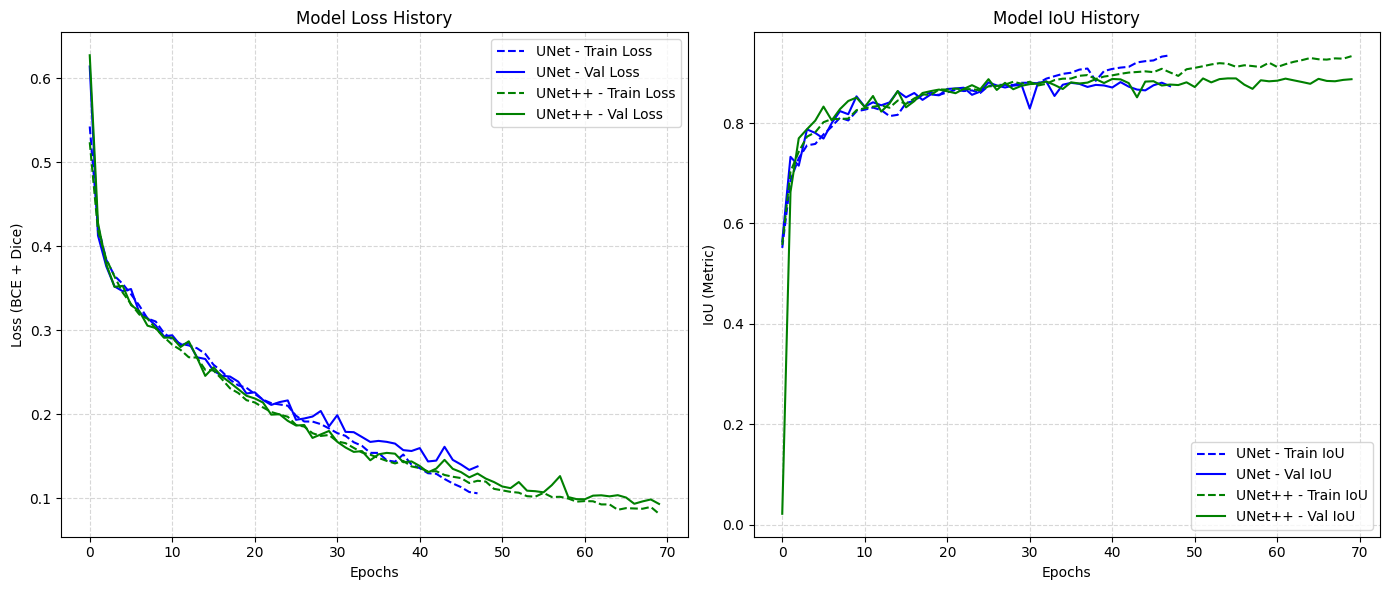

In [12]:
print("--- 8. Visualizing Training History ---")

# Lấy dữ liệu từ dictionary
unet_hist = training_histories["unet"]
unet_pp_hist = training_histories["unet_pp"]

# --- 1. Biểu đồ Loss ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
# UNet
plt.plot(unet_hist["train_loss"], label='UNet - Train Loss', color='blue', linestyle='--')
plt.plot(unet_hist["val_loss"], label='UNet - Val Loss', color='blue')
# UNet++
plt.plot(unet_pp_hist["train_loss"], label='UNet++ - Train Loss', color='green', linestyle='--')
plt.plot(unet_pp_hist["val_loss"], label='UNet++ - Val Loss', color='green')

plt.title('Model Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCE + Dice)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- 2. Biểu đồ IoU ---
plt.subplot(1, 2, 2)
# UNet
plt.plot(unet_hist["train_iou"], label='UNet - Train IoU', color='blue', linestyle='--')
plt.plot(unet_hist["val_iou"], label='UNet - Val IoU', color='blue')
# UNet++
plt.plot(unet_pp_hist["train_iou"], label='UNet++ - Train IoU', color='green', linestyle='--')
plt.plot(unet_pp_hist["val_iou"], label='UNet++ - Val IoU', color='green')

plt.title('Model IoU History')
plt.xlabel('Epochs')
plt.ylabel('IoU (Metric)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 9. Trực quan hóa kết quả

--- 7. Visualizing Results on TEST Set (Comparing UNet vs UNet++) ---
Loading best saved models...
Models loaded. Visualizing samples...


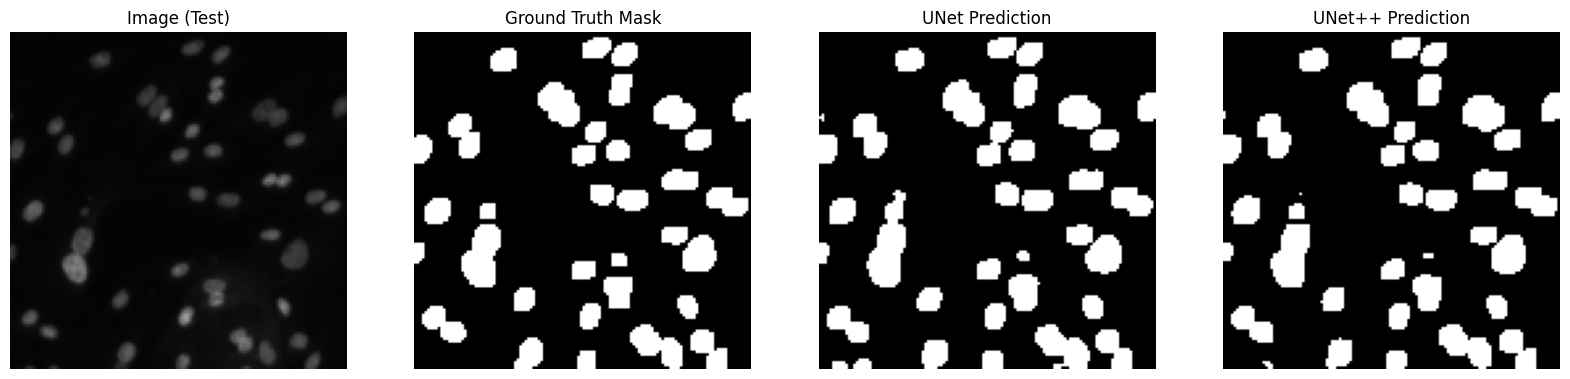

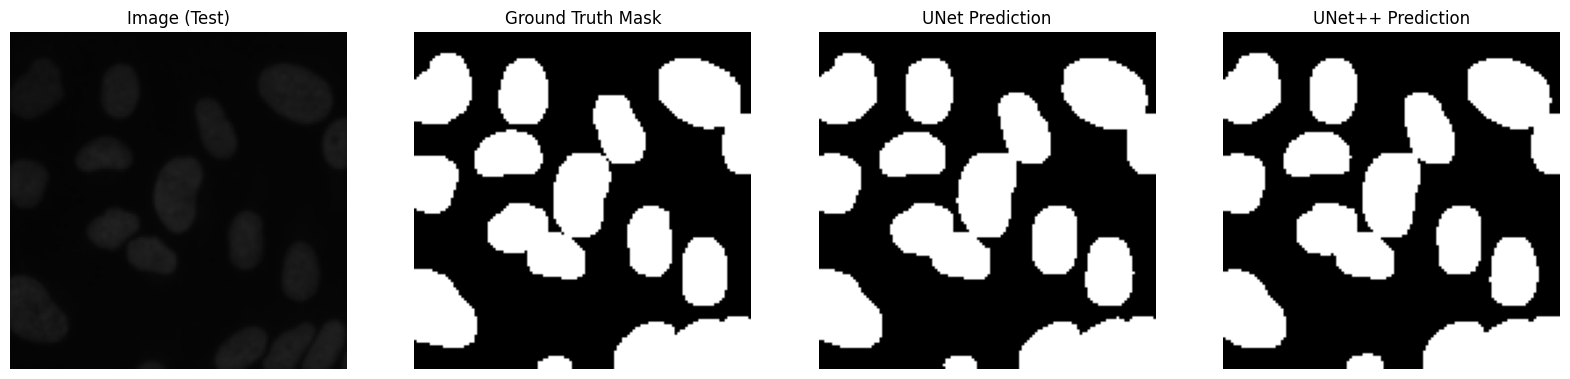

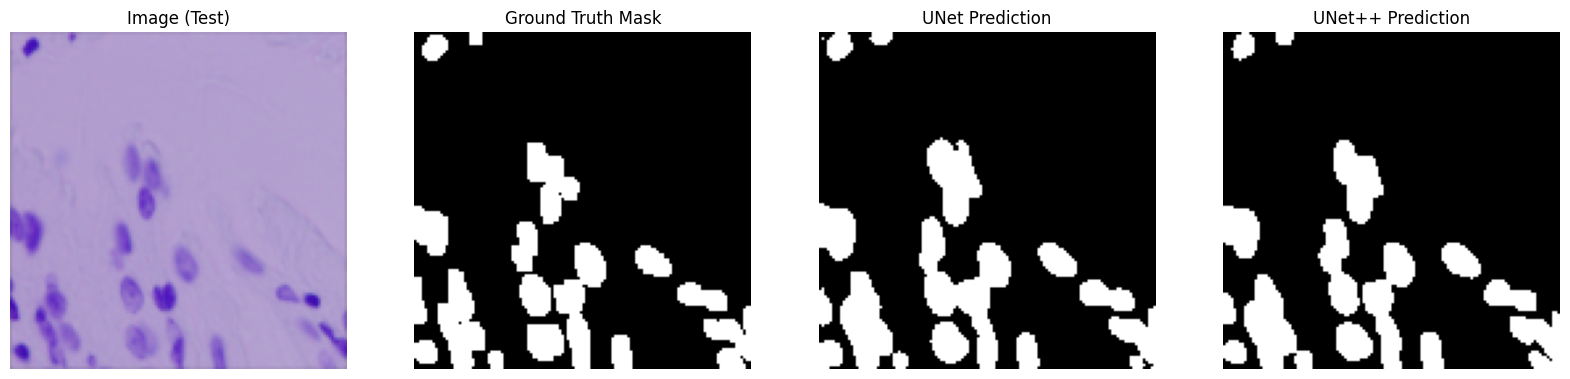

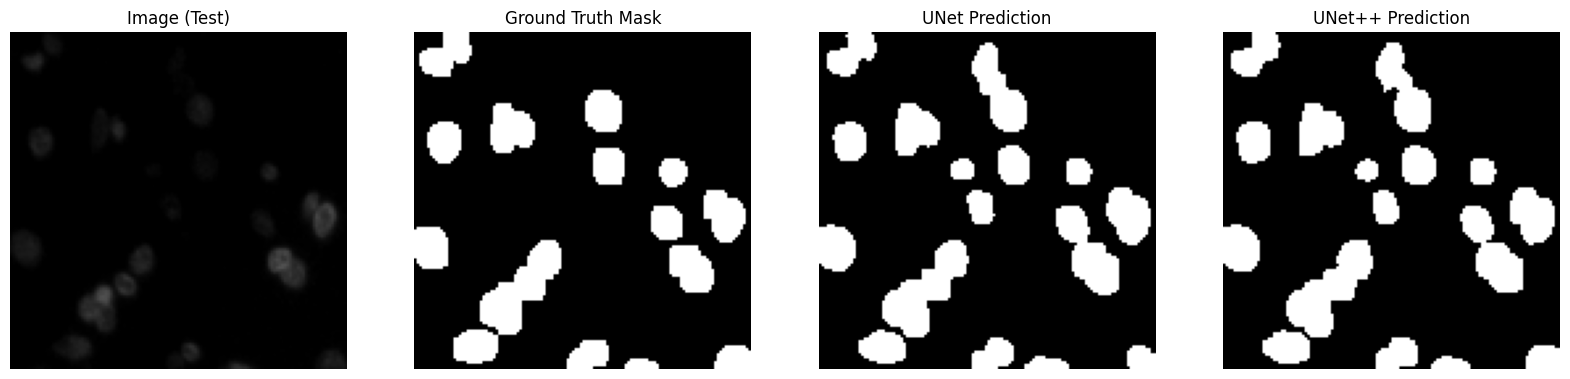

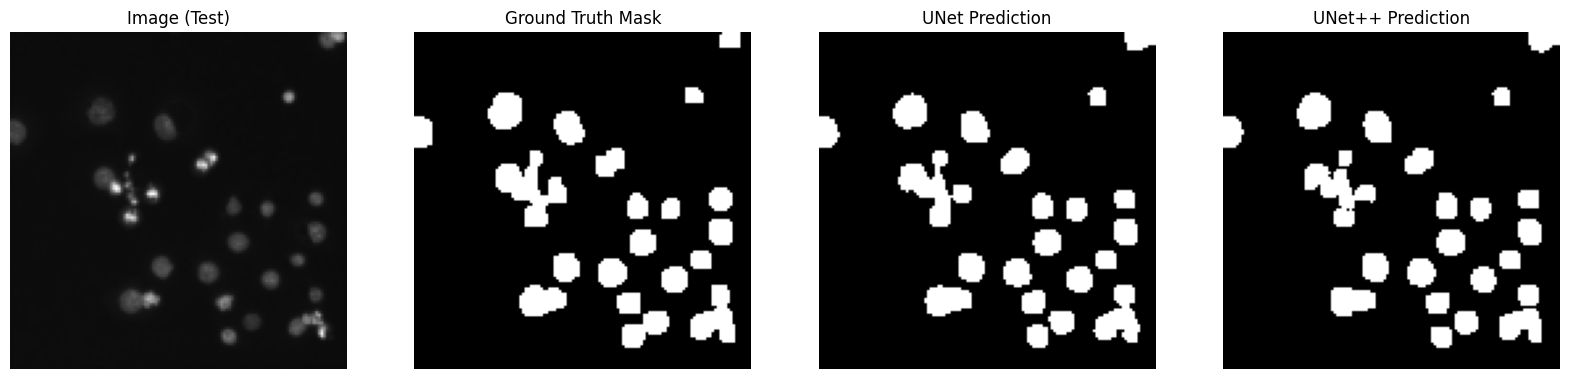

In [13]:
print("--- 7. Visualizing Results on TEST Set (Comparing UNet vs UNet++) ---")

# --- 1. Tải cả hai model tốt nhất ---
print("Loading best saved models...")
# Tải UNet
model_unet = UNet(in_channels=IMG_CHANNELS, out_channels=1).to(DEVICE)
model_unet.load_state_dict(torch.load(UNET_SAVE_PATH))
model_unet.eval()

# Tải UNet++
# (Giả sử model UNet++ tốt nhất đã được lưu với deep_supervision=True)
DEEP_SUPERVISION_FOR_LOADING = True 
model_unet_pp = UNetPlusPlus(in_channels=IMG_CHANNELS, out_channels=1, 
                             deep_supervision=DEEP_SUPERVISION_FOR_LOADING).to(DEVICE)
model_unet_pp.load_state_dict(torch.load(UNET_PLUS_PLUS_SAVE_PATH))
model_unet_pp.eval()

print("Models loaded. Visualizing samples...")

# --- 2. Lấy mẫu và dự đoán ---
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Lấy ảnh và mask từ test_dataset
        img, mask = test_dataset[idx]
        
        # Thêm chiều batch (1, C, H, W) và đưa lên GPU
        img_tensor = img.unsqueeze(0).to(DEVICE)
        
        # --- Dự đoán ---
        # UNet
        pred_unet = model_unet(img_tensor)
        pred_unet_np = (pred_unet.squeeze().cpu().numpy() > 0.5).astype(float)
        
        # UNet++
        pred_unet_pp = model_unet_pp(img_tensor)
        if DEEP_SUPERVISION_FOR_LOADING:
            pred_unet_pp = pred_unet_pp[-1] # Lấy output cuối cùng
        pred_unet_pp_np = (pred_unet_pp.squeeze().cpu().numpy() > 0.5).astype(float)
        
        # --- Chuyển đổi để vẽ ---
        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        
        # --- Vẽ 4 ảnh ---
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 4, 1)
        plt.title("Image (Test)")
        plt.imshow(img_np)
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("UNet Prediction")
        plt.imshow(pred_unet_np, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title("UNet++ Prediction")
        plt.imshow(pred_unet_pp_np, cmap='gray')
        plt.axis('off')
        
        plt.show()